In [1]:
import pandas.io.sql as psql
import json
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit import rdBase
from rdkit import DataStructs
#import psycopg2 as pg


import pandas as pd
import sqlalchemy as db
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from pandas import concat

from collections import OrderedDict
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

import cheminformatics.utils.multicore as multicore
import time
import math
from multiprocessing import Pool,Queue, Process, cpu_count
import os
import sys

import chemfp
from chemfp import search

import numpy as np

import random
from numpy import median 
from itertools import combinations

from rdkit.Chem import QED 

# read core info

In [2]:
pool = pd.read_csv("../03_target_pred/Results/query_with_targets.csv",encoding='utf-8')

In [3]:
print(pool.shape)
pool.head()

(1448145, 3)


query_index                   query_smiles                  targets
0         9812   C1CCCC(N2CCN(C3CCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
1        13121   C1CCC(N2CCN(C3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
2         9438  C1CCCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
3        12848   C1CCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
4        12853  C1CCC(N2CCC(N3CCCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}

In [4]:
targets_novelty_scores = pd.read_csv("../01_chembl_data_prep/Results/targets_with_novelty_scores.csv",encoding='utf-8')

In [5]:
targets_novelty_scores.head()

target_chembl_id   clan     pfam  clan_novelty_score  pfam_novelty_score  \
0    CHEMBL1075021   c519  PF00204            0.880137            0.813719   
1    CHEMBL1075022   c637  PF00204            0.166667            0.813719   
2    CHEMBL1075023  c1484  PF01048            0.000000            0.269437   
3    CHEMBL1075024   c582  PF03060            0.250000            0.250000   
4    CHEMBL1075025  c1864  PF01255            0.000000            0.000000   

   in_actives  in_predicted  
0           1             0  
1           1             0  
2           1             1  
3           1             1  
4           1             1

In [6]:
clusters = pd.read_csv("../02_zinc15_data_prep/Results/parsed_clusers_04.csv")
clusters['cluster_id'] = np.where((clusters.cluster_id == 'false_singleton'),clusters.member,clusters.member)
clusters.head()

/Home/ii/neannm/anaconda3/envs/rdkit3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cluster_id   member
0     1000192  1000192
1     1000844  1000844
2     1001115  1001115
3     1001430  1001430
4     1001929  1001929

# novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms

## fitness score evolution

In [7]:
evolution_scores = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms.csv",encoding='utf-8')

In [8]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [9]:
print(evolution_scores.shape)
evolution_scores.head()

(150000, 3)


fitness  generation   use
0  0.582282           0  True
1  0.589584           0  True
2  0.588197           0  True
3  0.580212           0  True
4  0.587202           0  True

In [10]:
evolution_scores.tail()

fitness  generation    use
149995  0.740632         299  False
149996  0.736513         299  False
149997  0.737580         299  False
149998  0.710324         299  False
149999  0.676870         299  False

In [11]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.582282           0  True
1  0.589584           0  True
2  0.588197           0  True
3  0.580212           0  True
4  0.587202           0  True

Text(0, 0.5, 'fitness')

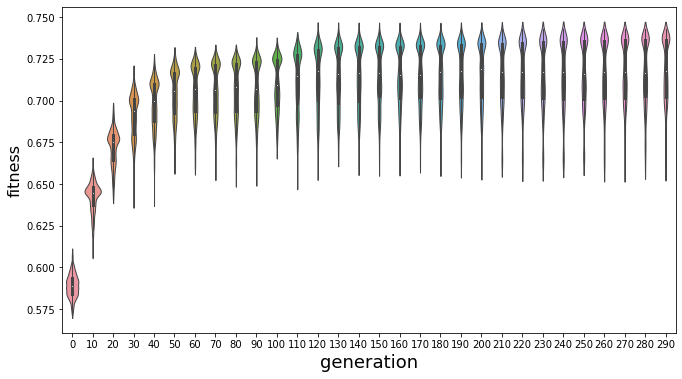

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [13]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.609979   True
1           1  0.621314  False
2           2  0.632897  False
3           3  0.633810  False
4           4  0.640948  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

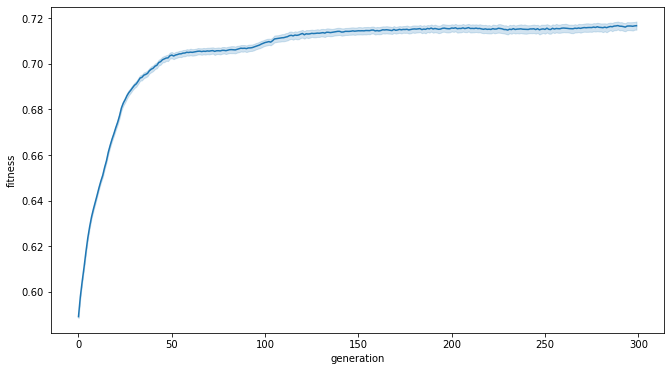

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

(array([0.6 , 0.65, 0.7 , 0.75]),
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

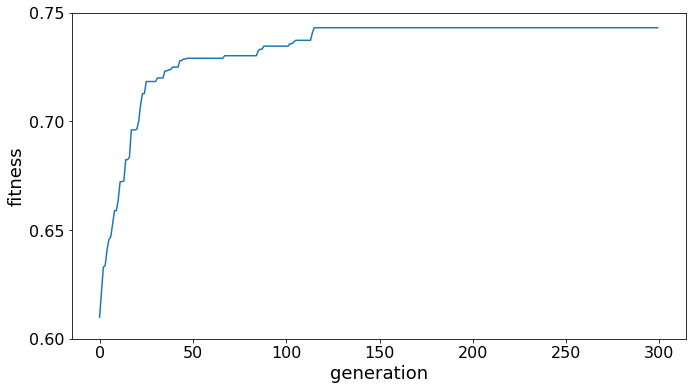

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.6,0.75, .05))
plt.yticks(fontsize=16)

In [16]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.6099785205287759
max overall: 0.7430661533470272
improvement: 21.818412999671004


## population scaffold change

In [17]:
best_pop_at_0 = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [18]:
best_pop_overall = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms_115.csv",encoding='utf-8',names=['file_index'])

In [19]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

5000
5000


In [20]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0    503829.0      2768017  O=C(Nc1ccc(Cn2cncn2)cc1)c1cccc(NC(=O)[C@@H]2CC...   
1    497891.0       199377          Cc1ccc(CN2CCC(Oc3cccc(F)c3)(C(=O)O)CC2)o1   
2   1384337.0      2335583             Nc1ccc(Oc2ccc(Cl)cc2S(=O)(=O)O)c(Cl)c1   
3    783521.0      2808860  O=C(NCc1ccc(F)cc1)C1CCN(S(=O)(=O)c2ccc(Cl)cc2)CC1   
4   1231981.0      1353641  CCOC1(OCC)N=C(N)[C@]2(C#N)[C@@H](c3ccccc3Cl)[C...   

                         targets  
0                   {CHEMBL5567}  
1                {CHEMBL1293231}  
2                   {CHEMBL4150}  
3  {CHEMBL1293299,CHEMBL1293254}  
4                   {CHEMBL4011}

In [21]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                       query_smiles  \
0   1304801.0      2019187  COc1ccc(Nc2c([N+](=O)[O-])cc(C(=O)O)cc2[N+](=O...   
1   1391229.0      2378777                       NCCCCc1nnc(SCc2ccc(Cl)cc2)o1   
2    879267.0      2265758           CSc1ccccc1/N=C/c1ccc(OCC(=O)N2CCOCC2)cc1   
3   1254658.0      1045161  CCC(=O)N1N=C2c3cc(OC)ccc3CC[C@H]2[C@@H]1c1cccc...   
4   1049532.0       689586    CCc1cc(-c2[nH]nc(C)c2-c2ccc3c(c2)OCCO3)c(O)cc1O   

                                             targets  
0                                       {CHEMBL4681}  
1  {CHEMBL3356,CHEMBL3622,CHEMBL289,CHEMBL1293231...  
2                            {CHEMBL6110,CHEMBL3577}  
3                                    {CHEMBL1075094}  
4  {CHEMBL2147,CHEMBL2073,CHEMBL3880,CHEMBL3717,C...

In [22]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [23]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [24]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 4098
max overall: 4109
% improvement: 0.26842362127867253
 improvement: 11


## cluster representation change

In [25]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0    503829.0      2768017  O=C(Nc1ccc(Cn2cncn2)cc1)c1cccc(NC(=O)[C@@H]2CC...   
1    497891.0       199377          Cc1ccc(CN2CCC(Oc3cccc(F)c3)(C(=O)O)CC2)o1   
2   1384337.0      2335583             Nc1ccc(Oc2ccc(Cl)cc2S(=O)(=O)O)c(Cl)c1   
3    783521.0      2808860  O=C(NCc1ccc(F)cc1)C1CCN(S(=O)(=O)c2ccc(Cl)cc2)CC1   
4   1231981.0      1353641  CCOC1(OCC)N=C(N)[C@]2(C#N)[C@@H](c3ccccc3Cl)[C...   

                         targets  \
0                   {CHEMBL5567}   
1                {CHEMBL1293231}   
2                   {CHEMBL4150}   
3  {CHEMBL1293299,CHEMBL1293254}   
4                   {CHEMBL4011}   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                       murcko_smiles  cluster_id   member  
0  O=C(Nc1ccc(Cn2cncn2)cc1)c1cccc(NC(=O)[C@@H]2CC...     2768017  2768017  
1                      c1ccc(OC2CCN(Cc3ccco3)CC2)cc1      199377   199377  
2                                c1ccc(Oc2ccccc2)cc1     2335583  2335583  
3         O=C(NCc1ccccc1)C1CCN(S(=O)(=O)c2ccccc2)CC1     2808860  2808860  
4                            C1=NCC2C1[C@H]2c1ccccc1     1353641  1353641
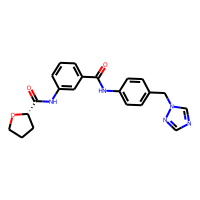
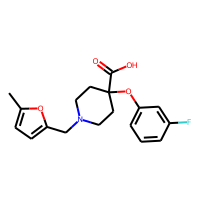
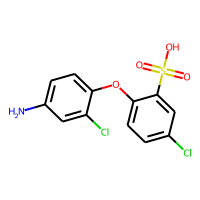
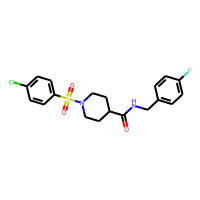
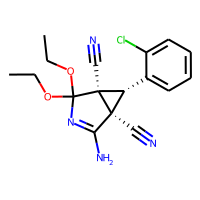

In [26]:
best_pop_at_0.head()

In [27]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 5000
max overall: 5000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [28]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(8481, 1)
(919, 1)
7562


targets
0     CHEMBL5567
1  CHEMBL1293231
2     CHEMBL4150
3  CHEMBL1293299
4  CHEMBL1293254

In [29]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(9513, 1)
(951, 1)
8562


targets
0     CHEMBL4681
1     CHEMBL3356
2     CHEMBL3622
3      CHEMBL289
4  CHEMBL1293231

In [30]:
duplicate_overall - duplicate_at_0

1000

In [31]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 919
max overall: 951
% improvement: 3.4820457018498367
 improvement: 32


#### number of pfams

In [32]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [33]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0     CHEMBL5567       CHEMBL5567   c249  PF00501            0.926807   
1  CHEMBL1293231    CHEMBL1293231   c503  PF00105            1.000000   
2     CHEMBL4150       CHEMBL4150   c908  PF13561            0.072368   
3  CHEMBL1293299    CHEMBL1293299  c1441  PF05965            1.000000   
4  CHEMBL1293254    CHEMBL1293254  c1658  PF00210            1.000000   

   pfam_novelty_score  in_actives  in_predicted  
0            0.917624           1             1  
1            0.819929           1             1  
2            0.545952           1             1  
3            1.000000           1             1  
4            1.000000           1             1

In [34]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(970, 8)
(1092, 8)


In [35]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 351
max overall: 437
% improvement: 24.501424501424502
 improvement: 86


### change in median novelty score

In [36]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.7502971093830421
max overall: 0.7502971093830421
% improvement: 0.0
 improvement: 0.0


# novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms

## fitness score evolution

In [37]:
evolution_scores = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms.csv",encoding='utf-8')

In [38]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [39]:
print(evolution_scores.shape)
evolution_scores.head()

(300000, 3)


fitness  generation   use
0  0.591614           0  True
1  0.593459           0  True
2  0.580588           0  True
3  0.581486           0  True
4  0.586242           0  True

In [40]:
evolution_scores.tail()

fitness  generation    use
299995  0.724705         299  False
299996  0.764713         299  False
299997  0.748968         299  False
299998  0.731248         299  False
299999  0.734924         299  False

In [41]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.591614           0  True
1  0.593459           0  True
2  0.580588           0  True
3  0.581486           0  True
4  0.586242           0  True

Text(0, 0.5, 'fitness')

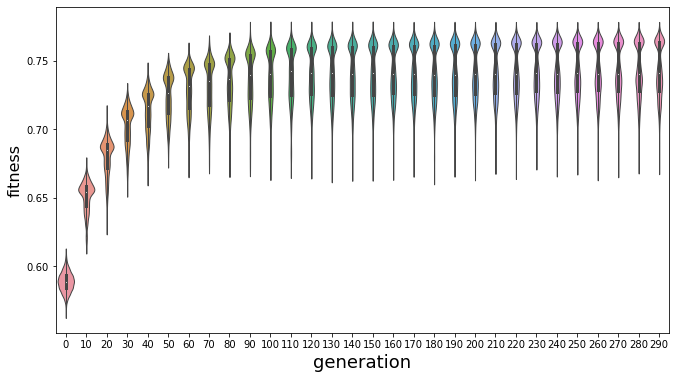

In [42]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [43]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.611580   True
1           1  0.621881  False
2           2  0.630308  False
3           3  0.644839  False
4           4  0.646894  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

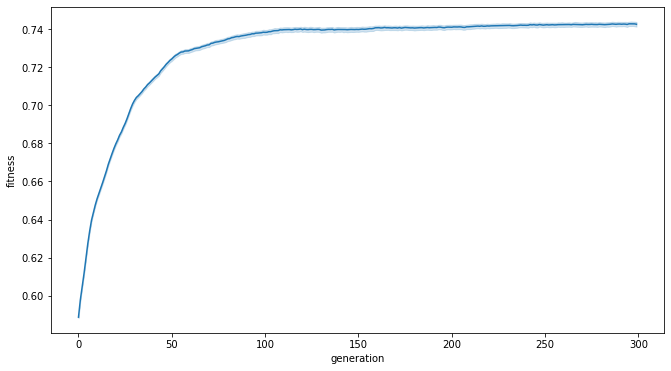

In [44]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

Text(0, 0.5, 'fitness')

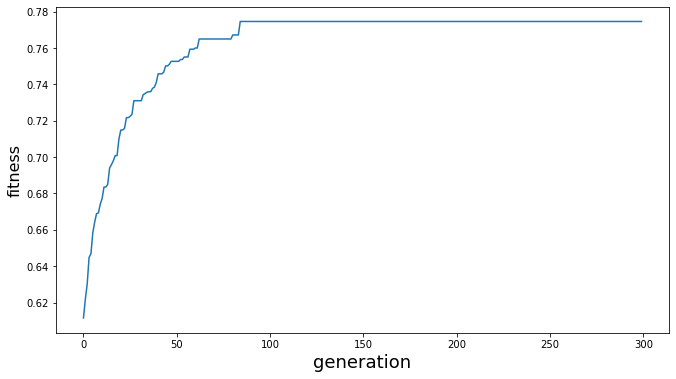

In [45]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [46]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.6115801560274711
max overall: 0.7745606695604699
improvement: 26.64908465827953


## population scaffold change

In [47]:
best_pop_at_0 = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [48]:
best_pop_overall = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms_84.csv",encoding='utf-8',names=['file_index'])

In [49]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

5000
5000


In [50]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0    416549.0       874367   CCCCOc1ccc(C(=O)N2CCN(c3cc(-n4ccnc4)ncn3)CC2)cc1   
1    855195.0      2808479             O=C(NCc1cccc(OC(F)(F)F)c1)[C@@H]1CCOC1   
2     97480.0        94652           C=c1ccc(=c2[nH]/c(=C\c3cccs3)c(=O)o2)cc1   
3   1234380.0      1595332  Cn1cc(S(=O)(=O)N2CCN(CC(=O)Nc3ccc(OC(F)F)cc3)C...   
4    616767.0      1621391  Cn1c(Sc2ccc(C3OC(=O)CC(=O)O3)cc2[N+](=O)[O-])n...   

           targets  
0  {CHEMBL1293255}  
1     {CHEMBL6110}  
2     {CHEMBL5567}  
3      {CHEMBL340}  
4     {CHEMBL3024}

In [51]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                     query_smiles  \
0    671745.0      1402387            CCOC(=O)c1oc2ccc(NC(=O)c3ccco3)cc2c1C   
1    901122.0      2255834                 COC(=O)CNC(=O)CCNC(=O)OCc1ccccc1   
2    237573.0      1965515              COc1cccc(NC(=O)CC2(CC(=O)O)CCCC2)c1   
3    270343.0      1297987  CCOc1cc(C2C3=C(CCCC3=O)N=C3CCCC(=O)C32)ccc1OCCO   
4   1105927.0       655937            Cc1noc(C)c1CCC(=O)Nc1cccc(-c2nnco2)c1   

                                             targets  
0  {CHEMBL1293294,CHEMBL5990,CHEMBL1293277,CHEMBL...  
1                                        {CHEMBL230}  
2                                    {CHEMBL1293254}  
3                                    {CHEMBL1293299}  
4                          {CHEMBL325,CHEMBL1163125}

In [52]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [53]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [54]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 4114
max overall: 4118
% improvement: 0.09722897423432182
 improvement: 4


## cluster representation change

In [55]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0    416549.0       874367   CCCCOc1ccc(C(=O)N2CCN(c3cc(-n4ccnc4)ncn3)CC2)cc1   
1    855195.0      2808479             O=C(NCc1cccc(OC(F)(F)F)c1)[C@@H]1CCOC1   
2     97480.0        94652           C=c1ccc(=c2[nH]/c(=C\c3cccs3)c(=O)o2)cc1   
3   1234380.0      1595332  Cn1cc(S(=O)(=O)N2CCN(CC(=O)Nc3ccc(OC(F)F)cc3)C...   
4    616767.0      1621391  Cn1c(Sc2ccc(C3OC(=O)CC(=O)O3)cc2[N+](=O)[O-])n...   

           targets                                           molecule  \
0  {CHEMBL1293255}  <img data-content="rdkit/molecule" src="data:i...   
1     {CHEMBL6110}  <img data-content="rdkit/molecule" src="data:i...   
2     {CHEMBL5567}  <img data-content="rdkit/molecule" src="data:i...   
3      {CHEMBL340}  <img data-content="rdkit/molecule" src="data:i...   
4     {CHEMBL3024}  <img data-content="rdkit/molecule" src="data:i...   

                                      murcko_smiles  cluster_id   member  
0         O=C(c1ccccc1)N1CCN(c2cc(-n3ccnc3)ncn2)CC1      874367   874367  
1                       O=C(NCc1ccccc1)[C@@H]1CCOC1     2808479  2808479  
2          C=c1ccc(=c2[nH]/c(=C\c3cccs3)c(=O)o2)cc1       94652    94652  
3      O=C(CN1CCN(S(=O)(=O)c2cn[nH]c2)CC1)Nc1ccccc1     1595332  1595332  
4  O=C1CC(=O)OC(c2ccc(Sc3nnc(-c4ccccc4)[nH]3)cc2)O1     1621391  1621391
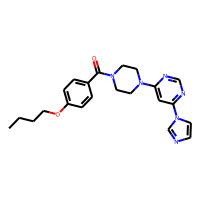
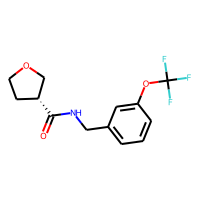
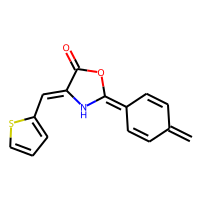
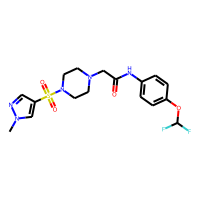
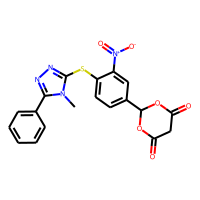

In [56]:
best_pop_at_0.head()

In [57]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 5000
max overall: 5000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [58]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(8307, 1)
(942, 1)
7365


targets
0  CHEMBL1293255
1     CHEMBL6110
2     CHEMBL5567
3      CHEMBL340
4     CHEMBL3024

In [59]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(9515, 1)
(1010, 1)
8505


targets
0  CHEMBL1293294
1     CHEMBL5990
2  CHEMBL1293277
3  CHEMBL1293303
4      CHEMBL230

In [60]:
duplicate_overall - duplicate_at_0

1140

In [61]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 942
max overall: 1010
% improvement: 7.218683651804671
 improvement: 68


#### number of pfams

In [62]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [63]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0  CHEMBL1293255    CHEMBL1293255  c1964  PF00106            1.000000   
1     CHEMBL6110       CHEMBL6110  c2281  PF07992            0.996305   
2     CHEMBL5567       CHEMBL5567   c249  PF00501            0.926807   
3      CHEMBL340        CHEMBL340    c48  PF00067            0.264734   
4     CHEMBL3024       CHEMBL3024   c552  PF00069            0.929847   

   pfam_novelty_score  in_actives  in_predicted  
0            0.634213           1             1  
1            0.961023           1             1  
2            0.917624           1             1  
3            0.398705           1             1  
4            0.757207           1             1

In [64]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(1012, 8)
(1154, 8)


In [65]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 359
max overall: 459
% improvement: 27.85515320334262
 improvement: 100


### change in median novelty score

In [66]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.691573370651739
max overall: 0.7502971093830421
% improvement: 8.491324452814288
 improvement: 0.0587237387313031


# novel7_elitist_pfam_novelty_parallel_5k_5000_300_0randoms

## fitness score evolution

In [67]:
evolution_scores = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_5000_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_5k_5000_300_0randoms.csv",encoding='utf-8')

In [68]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [69]:
print(evolution_scores.shape)
evolution_scores.head()

(1500000, 3)


fitness  generation   use
0  0.587291           0  True
1  0.586823           0  True
2  0.580223           0  True
3  0.595866           0  True
4  0.599089           0  True

In [70]:
evolution_scores.tail()

fitness  generation    use
1499995  0.847787         299  False
1499996  0.895225         299  False
1499997  0.840831         299  False
1499998  0.867717         299  False
1499999  0.894244         299  False

In [71]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.587291           0  True
1  0.586823           0  True
2  0.580223           0  True
3  0.595866           0  True
4  0.599089           0  True

Text(0, 0.5, 'fitness')

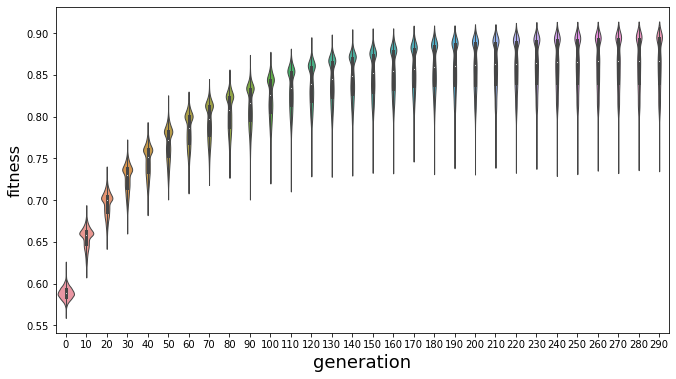

In [72]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [73]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.624849   True
1           1  0.627548  False
2           2  0.641933  False
3           3  0.649625  False
4           4  0.661214  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

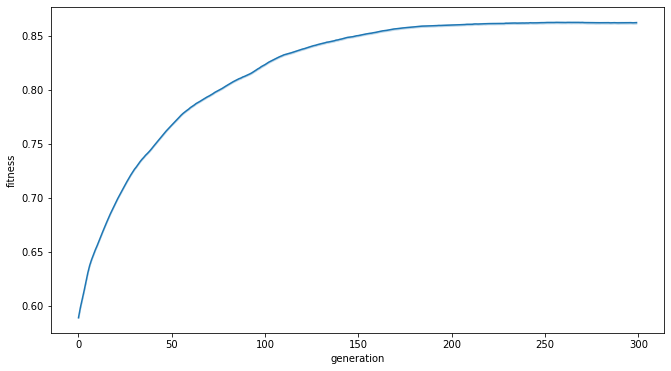

In [74]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

Text(0, 0.5, 'fitness')

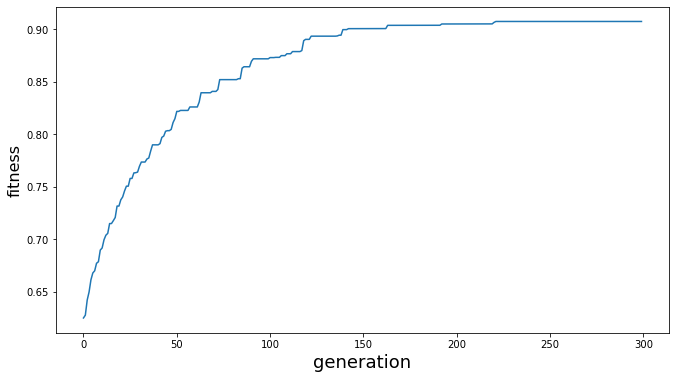

In [75]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [76]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.6248488995502698
max overall: 0.9073908826956733
improvement: 45.21764915466137


## population scaffold change

In [77]:
best_pop_at_0 = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_5000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_5k_5000_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [78]:
best_pop_overall = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_5000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_5k_5000_300_0randoms_221.csv",encoding='utf-8',names=['file_index'])

In [79]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

5000
5000


In [80]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                      query_smiles  \
0    389182.0      2194257               COC(=O)c1ccc(Cl)cc1OCC(=O)Nc1ccccc1   
1   1248848.0      1064631                C[C@H]1CCc2c(C(=O)NCc3ccco3)csc2C1   
2   1389151.0      2902320                    O=C(Oc1ccccc1N1CCOCC1)c1ccccc1   
3    568439.0       492717        Cc1c[nH]c(CNC(=O)N2CCC(Cc3ccc(F)cc3)CC2)n1   
4    528500.0      2303904  CS(=O)(=O)N1C[C@@H](C(=O)Nc2ccc(I)cc2)Oc2ccccc21   

                   targets  
0              {CHEMBL247}  
1          {CHEMBL1293255}  
2          {CHEMBL1293232}  
3          {CHEMBL1293254}  
4  {CHEMBL3356,CHEMBL3622}

In [81]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                       query_smiles  \
0   1024002.0      2972990    O=S(=O)(c1ccc(Cl)cc1)N1CCN(c2nc3ccccc3nc2Cl)CC1   
1   1037180.0      1823190    COc1ccc(C2(C(=O)N3CC[C@](O)(CN4CCCC4)C3)CC2)cc1   
2    270345.0      1297986  CCOc1cc(C2C3=C(CCCC3=O)N=C3CCCC(=O)C32)ccc1OCC...   
3   1253384.0      1507242  CCS(=O)(=O)Nc1ccc(C2=NN(C(C)=O)[C@H](c3ccccc3)...   
4   1327115.0      1600018  Cn1c(NCCN2CCOCC2)nc2c1c(=O)n(Cc1cccc(Cl)c1)c(=...   

                                       targets  
0                   {CHEMBL1075138,CHEMBL2179}  
1                                 {CHEMBL3622}  
2                              {CHEMBL1293299}  
3  {CHEMBL1293278,CHEMBL1075189,CHEMBL1075138}  
4                              {CHEMBL2146309}

In [82]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [83]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [84]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 4107
max overall: 4068
% improvement: -0.9495982468955442
 improvement: -39


## cluster representation change

In [85]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                      query_smiles  \
0    389182.0      2194257               COC(=O)c1ccc(Cl)cc1OCC(=O)Nc1ccccc1   
1   1248848.0      1064631                C[C@H]1CCc2c(C(=O)NCc3ccco3)csc2C1   
2   1389151.0      2902320                    O=C(Oc1ccccc1N1CCOCC1)c1ccccc1   
3    568439.0       492717        Cc1c[nH]c(CNC(=O)N2CCC(Cc3ccc(F)cc3)CC2)n1   
4    528500.0      2303904  CS(=O)(=O)N1C[C@@H](C(=O)Nc2ccc(I)cc2)Oc2ccccc21   

                   targets                                           molecule  \
0              {CHEMBL247}  <img data-content="rdkit/molecule" src="data:i...   
1          {CHEMBL1293255}  <img data-content="rdkit/molecule" src="data:i...   
2          {CHEMBL1293232}  <img data-content="rdkit/molecule" src="data:i...   
3          {CHEMBL1293254}  <img data-content="rdkit/molecule" src="data:i...   
4  {CHEMBL3356,CHEMBL3622}  <img data-content="rdkit/molecule" src="data:i...   

                          murcko_smiles  cluster_id   member  
0              O=C(COc1ccccc1)Nc1ccccc1     2194257  2194257  
1           O=C(NCc1ccco1)c1csc2c1CCCC2     1064631  1064631  
2        O=C(Oc1ccccc1N1CCOCC1)c1ccccc1     2902320  2902320  
3  O=C(NCc1ncc[nH]1)N1CCC(Cc2ccccc2)CC1      492717   492717  
4     O=C(Nc1ccccc1)[C@@H]1CNc2ccccc2O1     2303904  2303904
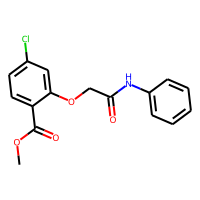
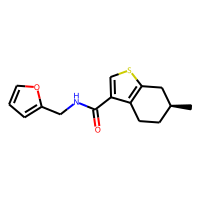
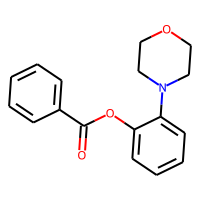
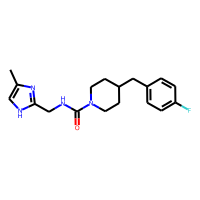
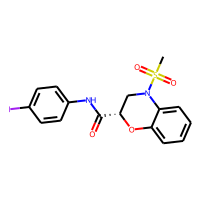

In [86]:
best_pop_at_0.head()

In [87]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 5000
max overall: 5000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [88]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(8229, 1)
(905, 1)
7324


targets
0      CHEMBL247
1  CHEMBL1293255
2  CHEMBL1293232
3  CHEMBL1293254
4     CHEMBL3356

In [89]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(11061, 1)
(1026, 1)
10035


targets
0  CHEMBL1075138
1     CHEMBL2179
2     CHEMBL3622
3  CHEMBL1293299
4  CHEMBL1293278

In [90]:
duplicate_overall - duplicate_at_0

2711

In [91]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 905
max overall: 1026
% improvement: 13.370165745856355
 improvement: 121


#### number of pfams

In [92]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [93]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0      CHEMBL247        CHEMBL247     c1  PF06815            0.295583   
1  CHEMBL1293255    CHEMBL1293255  c1964  PF00106            1.000000   
2  CHEMBL1293232    CHEMBL1293232  c1757  PF06003            0.013047   
3  CHEMBL1293254    CHEMBL1293254  c1658  PF00210            1.000000   
4     CHEMBL3356       CHEMBL3356   c195  PF00067            0.853319   

   pfam_novelty_score  in_actives  in_predicted  
0            0.071788           1             1  
1            0.634213           1             1  
2            0.013047           1             1  
3            1.000000           1             1  
4            0.398705           1             1

In [94]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(1050, 8)
(1185, 8)


In [95]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 417
max overall: 457
% improvement: 9.59232613908873
 improvement: 40


### change in median novelty score

In [96]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.7462750409923721
max overall: 0.7502971093830421
% improvement: 0.5389525536485277
 improvement: 0.004022068390669986
